## Export Multiple Attention Images - with mods

- Small mods to make my american flag key and query example more similia

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import transformer_lens
import torch.nn as nn
import einops
from jaxtyping import Float, Int
import torch as t
from torch import Tensor
from dataclasses import dataclass
import os, shutil, sys

In [3]:
output_dir='gpt_2_attention_viz_4'

```
rsync -auv stephen@dev-3:/home/stephen/deepseek /Users/stephen/Dropbox/welch_labs/deepseek/hackin/linux_workdir --exclude DeepSeek-V3
```

In [4]:
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

In [5]:
sys.path.append('/home/stephen/deepseek/ARENA_3.0-main/chapter1_transformer_interp/exercises')
import part1_transformer_from_scratch.tests as tests

In [6]:
device='cuda'
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


### Start with 10 tokens, cut down as needed for viz to work

In [7]:
# reference_text = "The American flag is red, white, and"
reference_text = "The American flag is red, white, and"

In [8]:
tokens = model.to_tokens(reference_text).to(device)
logits, cache = model.run_with_cache(tokens)
logits.shape

torch.Size([1, 10, 50257])

In [9]:
def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    output = layer(input)
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape)
    try:
        reference_output = gpt2_layer(input)
    except:
        reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
    assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

In [10]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


In [11]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = (
            einops.einsum(
                normalized_resid_pre, self.W_Q, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_Q
        )
        k = (
            einops.einsum(
                normalized_resid_pre, self.W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_K
        )
        v = (
            einops.einsum(
                normalized_resid_pre, self.W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_V
        )

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head**0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern, "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head"
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = (
            einops.einsum(z, self.W_O, "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model")
            + self.b_O
        )

        return attn_out

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


# tests.test_causal_mask(Attention.apply_causal_mask)
# rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, model.blocks[0].attn, cache["normalized", 0, "ln1"])

Input shape: torch.Size([1, 10, 768])
Output shape: torch.Size([1, 10, 768])
Reference output shape: torch.Size([1, 10, 768]) 

100.00% of the values are correct



In [12]:
cfg = Config(debug=True)
layer = Attention(cfg).to(device)
layer.load_state_dict(model.blocks[0].attn.state_dict(), strict=False);

output = layer(cache["normalized", 0, "ln1"])
reference_output = model.blocks[0].attn(cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"])

comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

100.00% of the values are correct



In [13]:
layer_id=2

In [14]:
cfg = Config(debug=True)
layer = Attention(cfg).to(device)
layer.load_state_dict(model.blocks[layer_id].attn.state_dict(), strict=False);

In [15]:
W_Q=layer.W_Q 
W_K=layer.W_K
W_V=layer.W_V
W_O=layer.W_O 
b_Q=layer.b_Q
b_K=layer.b_K 
b_V=layer.b_V 
b_O=layer.b_O

In [16]:
W_Q.shape, W_K.shape, W_V.shape, W_O.shape

(torch.Size([12, 768, 64]),
 torch.Size([12, 768, 64]),
 torch.Size([12, 768, 64]),
 torch.Size([12, 64, 768]))

In [17]:
normalized_resid_pre=cache["normalized", layer_id, "ln1"] #This i think?

In [18]:
normalized_resid_pre.shape

torch.Size([1, 10, 768])

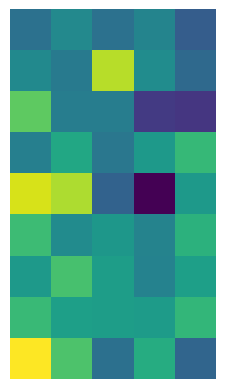

In [19]:
x_numpy=normalized_resid_pre.detach().cpu().numpy()[0]
plt.imshow(x_numpy[1:,:5])
plt.axis('off')
plt.savefig(output_dir+'/input_1_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [20]:
x_numpy.shape

(10, 768)

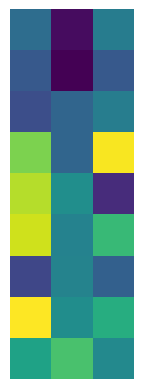

In [21]:
plt.imshow(x_numpy[1:,-3:])
plt.axis('off')
plt.savefig(output_dir+'/input_2_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

## Work out mods here then export

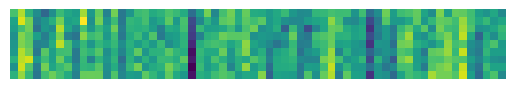

In [22]:
head_id=0

#There's more efficient ways to do this -> but this is one matrix multiply per head 
qs=[]
for head_num in range(cfg.n_heads):
    qs.append(normalized_resid_pre[0] @ W_Q[head_num] +b_Q[head_num]) 
q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.

q_to_viz=q[0,1:,head_id,:].detach().cpu().numpy()

plt.clf()
plt.imshow(q_to_viz)
plt.axis('off')
# plt.savefig(output_dir+'/'+str(head_id)+'/q_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

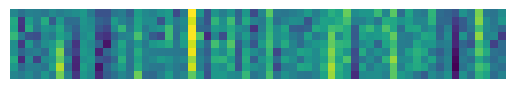

In [23]:

k = (
    einops.einsum(
        normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_K
)

plt.clf()
k_to_viz=k[0,1:,head_id,:].detach().cpu().numpy()
plt.imshow(k_to_viz)
plt.axis('off')
# plt.savefig(output_dir+'/'+str(head_id)+'/k_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

Maybe too aggressive, will see how it feels

In [24]:
alpha=0.1
k_to_viz[1,:]=alpha*k_to_viz[1,:]+(1-alpha)*q_to_viz[2,:] #+0.05*np.random.randn(64)

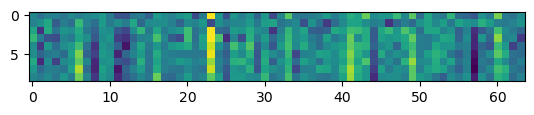

In [25]:
plt.imshow(k_to_viz)
plt.show()

In [26]:
# np.random.randn(64)

In [27]:
# k_to_viz

In [28]:
for head_id in range(12):

    if os.path.exists(output_dir+'/'+str(head_id)):
        shutil.rmtree(output_dir+'/'+str(head_id))
    os.makedirs(output_dir+'/'+str(head_id))
    
    #There's more efficient ways to do this -> but this is one matrix multiply per head 
    qs=[]
    for head_num in range(cfg.n_heads):
        qs.append(normalized_resid_pre[0] @ W_Q[head_num] +b_Q[head_num]) 
    q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.
    
    q_to_viz=q[0,1:,head_id,:].detach().cpu().numpy()

    
    k = (
        einops.einsum(
            normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
        )
        + b_K
    )
    
    k_to_viz=k[0,1:,head_id,:].detach().cpu().numpy()

    if head_id==0: #Modify to make more visually similiar for video example
        alpha=0.75
        q_to_viz[2,:]=alpha*q_to_viz[2,:]+(1-alpha)*k_to_viz[1,:]

    if head_id==0: #Modify to make more visually similiar for video example
        alpha=0.5
        k_to_viz[1,:]=alpha*k_to_viz[1,:]+(1-alpha)*q_to_viz[2,:]
        
    plt.clf()
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(output_dir+'/'+str(head_id)+'/q_1.png', dpi=150, transparent=True, bbox_inches='tight')

    plt.clf()
    plt.imshow(k_to_viz)
    plt.axis('off')
    plt.savefig(output_dir+'/'+str(head_id)+'/k_1.png', dpi=150, transparent=True, bbox_inches='tight')

    v = (
    einops.einsum(
        normalized_resid_pre, W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_V
    )
    
    v_to_viz=v[0,1:,head_id,:].detach().cpu().numpy()
    plt.clf()
    plt.imshow(v_to_viz)
    plt.axis('off')
    plt.savefig(output_dir+'/'+str(head_id)+'/v_1.png', dpi=150, transparent=True, bbox_inches='tight')

    # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
    attn_scores = einops.einsum(
        q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
    )
    
    attn_scores_masked = layer.apply_causal_mask(attn_scores / layer.cfg.d_head**0.5)
    attn_pattern = attn_scores_masked.softmax(-1)

    plt.clf()
    attn_scores_to_viz=attn_scores[0,head_id,1:,1:].detach().cpu().numpy()
    plt.imshow(attn_scores_to_viz)
    plt.axis('off')
    plt.savefig(output_dir+'/'+str(head_id)+'/attention_scores.png', dpi=150, transparent=True, bbox_inches='tight')

    plt.clf()
    attn_pattern_to_viz=attn_pattern[0,head_id,1:,1:].detach().cpu().numpy()
    plt.imshow(attn_pattern_to_viz)
    plt.axis('off')
    plt.savefig(output_dir+'/'+str(head_id)+'/attention_pattern.png', dpi=150, transparent=True, bbox_inches='tight')

    zs=[]
    for head_num in range(cfg.n_heads):
        zs.append(attn_pattern[0, head_num, :, :] @ v[0, :, head_num, :])

    plt.clf()
    z_to_viz=zs[head_id][1:, :].detach().cpu().numpy()
    plt.imshow(z_to_viz)
    plt.axis('off')
    plt.savefig(output_dir+'/'+str(head_id)+'/z_1.png', dpi=150, transparent=True, bbox_inches='tight')

---

### Export Queries and Keys as Separate Rows

In [29]:
head_id=0

# if os.path.exists(output_dir+'/'+str(head_id)):
#     shutil.rmtree(output_dir+'/'+str(head_id))
# os.makedirs(output_dir+'/'+str(head_id))

#There's more efficient ways to do this -> but this is one matrix multiply per head 
qs=[]
for head_num in range(cfg.n_heads):
    qs.append(normalized_resid_pre[0] @ W_Q[head_num] +b_Q[head_num]) 
q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.

q_to_viz=q[0,1:,head_id,:].detach().cpu().numpy()

k = (
    einops.einsum(
        normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_K
)

k_to_viz=k[0,1:,head_id,:].detach().cpu().numpy()

if head_id==0: #Modify to make more visually similiar for video example
    alpha=0.75
    q_to_viz[2,:]=alpha*q_to_viz[2,:]+(1-alpha)*k_to_viz[1,:]

if head_id==0: #Modify to make more visually similiar for video example
    alpha=0.5
    k_to_viz[1,:]=alpha*k_to_viz[1,:]+(1-alpha)*q_to_viz[2,:]

In [30]:
for row_to_viz in range(9):
    plt.clf()
    plt.imshow(q_to_viz[row_to_viz,:].reshape(1, 64))
    plt.axis('off')
    # plt.show()
    plt.savefig(output_dir+'/query_row_'+str(row_to_viz)+'.png', dpi=150, transparent=True, bbox_inches='tight')

for row_to_viz in range(9):
    plt.clf()
    plt.imshow(k_to_viz[row_to_viz,:].reshape(1, 64))
    plt.axis('off')
    # plt.show()
    plt.savefig(output_dir+'/key_row_'+str(row_to_viz)+'.png', dpi=150, transparent=True, bbox_inches='tight')

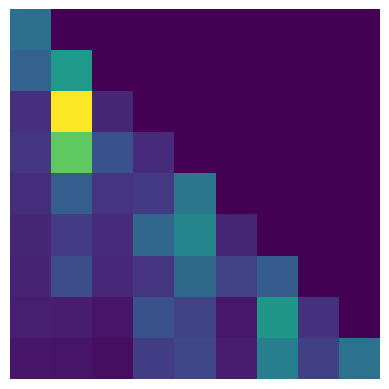

In [31]:

v = (
einops.einsum(
    normalized_resid_pre, W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
)
+ b_V
)

v_to_viz=v[0,1:,head_id,:].detach().cpu().numpy()
# plt.clf()
# plt.imshow(v_to_viz)
# plt.axis('off')
# plt.savefig(output_dir+'/'+str(head_id)+'/v_1.png', dpi=150, transparent=True, bbox_inches='tight')

# Calculate attention scores, then scale and mask, and apply softmax to get probabilities
attn_scores = einops.einsum(
    q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
)

attn_scores_masked = layer.apply_causal_mask(attn_scores / layer.cfg.d_head**0.5)
attn_pattern = attn_scores_masked.softmax(-1)

# plt.clf()
# attn_scores_to_viz=attn_scores[0,head_id,1:,1:].detach().cpu().numpy()
# plt.imshow(attn_scores_to_viz)
# plt.axis('off')
# plt.savefig(output_dir+'/'+str(head_id)+'/attention_scores.png', dpi=150, transparent=True, bbox_inches='tight')

plt.clf()
attn_pattern_to_viz=attn_pattern[0,head_id,1:,1:].detach().cpu().numpy()
plt.imshow(attn_pattern_to_viz)
plt.axis('off')
# plt.savefig(output_dir+'/'+str(head_id)+'/attention_pattern.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()


In [32]:
# zs=[]
# for head_num in range(cfg.n_heads):
#     zs.append(attn_pattern[0, head_num, :, :] @ v[0, :, head_num, :])

# plt.clf()
# z_to_viz=zs[head_id][1:, :].detach().cpu().numpy()
# plt.imshow(z_to_viz)
# plt.axis('off')
# plt.savefig(output_dir+'/'+str(head_id)+'/z_1.png', dpi=150, transparent=True, bbox_inches='tight')

In [33]:
   # #There's more efficient ways to do this -> but this is one matrix multiply per head 
   #  qs=[]
   #  for head_num in range(cfg.n_heads):
   #      qs.append(normalized_resid_pre[0] @ W_Q[head_num] +b_Q[head_num]) 
   #  q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.
    
   #  q_to_viz=q[0,1:,head_id,:].detach().cpu().numpy()
    
   #  plt.clf()
   #  plt.imshow(q_to_viz)
   #  plt.axis('off')
   #  plt.savefig(output_dir+'/'+str(head_id)+'/q_1.png', dpi=150, transparent=True, bbox_inches='tight')
    
   #  k = (
   #      einops.einsum(
   #          normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
   #      )
   #      + b_K
   #  )
    
   #  plt.clf()
   #  k_to_viz=k[0,1:,head_id,:].detach().cpu().numpy()
   #  plt.imshow(k_to_viz)
   #  plt.axis('off')
   #  plt.savefig(output_dir+'/'+str(head_id)+'/k_1.png', dpi=150, transparent=True, bbox_inches='tight')

In [34]:
# z_to_viz=z.detach().cpu().numpy()
# plt.imshow(z_to_viz)
# plt.axis('off')
# plt.savefig(output_dir+'/z_all_heads_1.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [35]:
# z_to_viz=z.detach().cpu().numpy()
# plt.imshow(z_to_viz[:,:12])
# plt.axis('off')
# plt.savefig(output_dir+'/z_all_heads_start_1.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [36]:
# z_to_viz=z.detach().cpu().numpy()
# plt.imshow(z_to_viz[:, -8:])
# plt.axis('off')
# plt.savefig(output_dir+'/z_all_heads_end_1.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [37]:
# attn_out.shape

In [38]:
# attn_out_to_viz=attn_out.detach().cpu().numpy()
# plt.imshow(attn_out_to_viz[:,:7])
# plt.axis('off')
# plt.savefig(output_dir+'/attn_out_start_1.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [39]:
# attn_out_to_viz=attn_out.detach().cpu().numpy()
# plt.imshow(z_to_viz[:,:5])
# plt.axis('off')
# plt.savefig(output_dir+'/attn_out_end_1.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

----

In [40]:
# token_string_list=model.to_str_tokens(tokens)
# attn_pattern=cache['blocks.10.attn.hook_pattern']
# fig=figure(0,(12,8))
# for i in range(12):
#     ax=fig.add_subplot(3,4,i+1)
#     plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
#     ax.set_xticks(np.arange(len(token_string_list)))
#     ax.set_xticklabels(token_string_list)
#     plt.xticks(rotation=90)
#     ax.set_yticks(np.arange(len(token_string_list)))
#     ax.set_yticklabels(token_string_list)
# plt.show()